# Chunking - Mihajlo

Chronologically, I did this exercise second, after the Name Entity Recognition (NER) one, so my explanations will be shortened, and some code will be reused from the NER case. I won't use the part-of-speech tag in the modeling, but it's still added to the dataset.

In [6]:
# Some imports and settings needed for counting and plotting
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = 12,9
import json
import os

# Imports for numerical data and ML
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import backend as K

## 1. Data import and parsing

Let's start by building our dataset in the same way as in NER. The resulting dataset is a list of tuples ((<current word>, <part of speech tag>, <chunk tag>))

In [1]:
def get_dataset(file):
    """
    Read the dataset in `file` line-by-line and return a list of sentences.
    
    :param file: A String containing the path to the text document containing data. 
    
    return: A list of sentences, where each sentence is a list of tuples:
            (<current word>, <part of speech tag>, <chunk tag>, <name entity tag>)
    """
    print("Creating dataset...", end=" ")
    
    dataset = []
    
    with open(file, "r") as file:
    
        sentence = []

        # Read all lines one by one
        for line in file:
            line_items = line.split()

            # Ignore DOCSTART lines
            if 'DOCSTART' in line:
                continue

            # If empty row, add sentence to dataset and re-initialise it
            if len(line_items) == 0:

                if len(sentence) > 0:
                    dataset.append(sentence)
                sentence = []
                continue

            # If row is not empty add word to sentence
            if len(line_items) > 0:
                sentence.append(tuple(line_items))

    print("done.")
    return dataset


In [3]:
# Example use
dataset = get_dataset(file="Datasets/chunking_dataset.txt")
print("An example sentence:")
print(dataset[0])

Creating dataset... done.
An example sentence:
[('Confidence', 'NN', 'B-NP'), ('in', 'IN', 'B-PP'), ('the', 'DT', 'B-NP'), ('pound', 'NN', 'I-NP'), ('is', 'VBZ', 'B-VP'), ('widely', 'RB', 'I-VP'), ('expected', 'VBN', 'I-VP'), ('to', 'TO', 'I-VP'), ('take', 'VB', 'I-VP'), ('another', 'DT', 'B-NP'), ('sharp', 'JJ', 'I-NP'), ('dive', 'NN', 'I-NP'), ('if', 'IN', 'B-SBAR'), ('trade', 'NN', 'B-NP'), ('figures', 'NNS', 'I-NP'), ('for', 'IN', 'B-PP'), ('September', 'NNP', 'B-NP'), (',', ',', 'O'), ('due', 'JJ', 'B-ADJP'), ('for', 'IN', 'B-PP'), ('release', 'NN', 'B-NP'), ('tomorrow', 'NN', 'B-NP'), (',', ',', 'O'), ('fail', 'VB', 'B-VP'), ('to', 'TO', 'I-VP'), ('show', 'VB', 'I-VP'), ('a', 'DT', 'B-NP'), ('substantial', 'JJ', 'I-NP'), ('improvement', 'NN', 'I-NP'), ('from', 'IN', 'B-PP'), ('July', 'NNP', 'B-NP'), ('and', 'CC', 'I-NP'), ('August', 'NNP', 'I-NP'), ("'s", 'POS', 'B-NP'), ('near-record', 'JJ', 'I-NP'), ('deficits', 'NNS', 'I-NP'), ('.', '.', 'O')]


## 2. Descriptive stats

So same code as in the NER case, only this time it's used on a different datset.

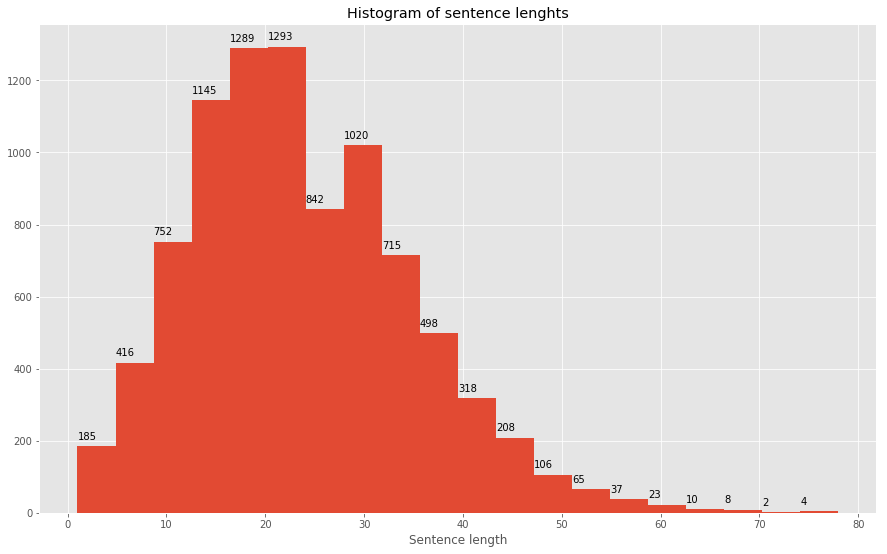

Chunking tags, sorted by number of appearances:
[('I-NP', 63307), ('B-NP', 55081), ('O', 27902), ('B-VP', 21467), ('B-PP', 21281), ('I-VP', 12003), ('B-ADVP', 4227), ('B-SBAR', 2207), ('B-ADJP', 2060), ('I-ADJP', 643), ('B-PRT', 556), ('I-ADVP', 443), ('I-PP', 291), ('I-CONJP', 73), ('I-SBAR', 70), ('B-CONJP', 56), ('B-INTJ', 31), ('B-LST', 10), ('I-INTJ', 9), ('I-UCP', 6), ('I-PRT', 2), ('B-UCP', 2)]


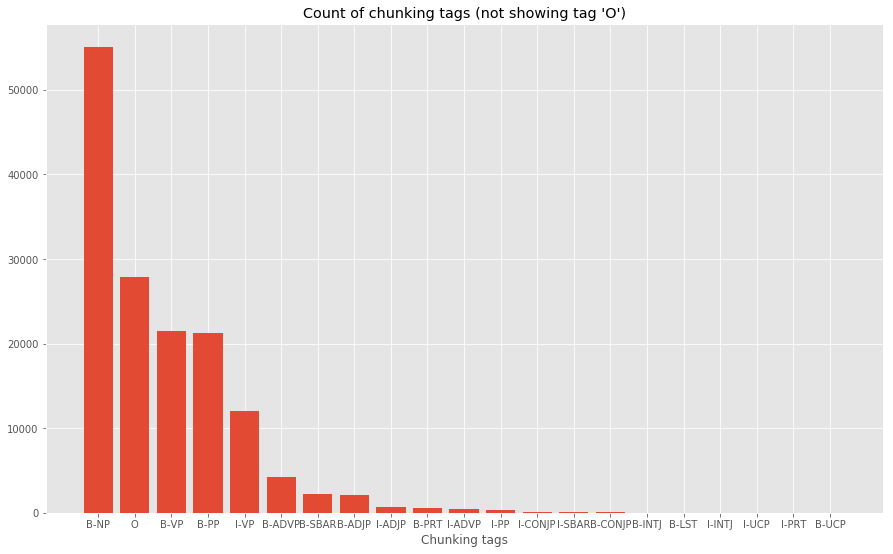

Number of sentences: 8936.
Number of words: 211727.
Number of unique words: 19122.


In [9]:
# Get the senence lengths in a list
sentence_lengths = [len(sentence) for sentence in dataset]

hist_results = plt.hist(sentence_lengths, 20)
for i in range(len(hist_results[0])):
    plt.text(x=hist_results[1][i] , y=hist_results[0][i] + 20, s="%d" % hist_results[0][i], size = 10)
plt.xlabel("Sentence length")
plt.title("Histogram of sentence lenghts")
plt.show()

# Count the unique Name Entity Tags
count_chunk_tags = Counter([row[2] for sentence in dataset for row in sentence])
print("Chunking tags, sorted by number of appearances:")
print(count_chunk_tags.most_common())

# A quick plot can also help. I'll exclude the 'O' tag here since it's not part of an entity
plt.rcParams['figure.figsize'] = 15,9
plt.figure()
tags, counts = zip(*count_chunk_tags.most_common()[1:])
plt.bar(tags, counts)
plt.xlabel("Chunking tags")
plt.title("Count of chunking tags (not showing tag 'O')")
plt.show()
plt.rcParams['figure.figsize'] = 12,9

word_list = [word[0] for sentence in dataset for word in sentence]
unique_words = set(word_list)
print("Number of sentences: %d." % len(dataset))
print("Number of words: %d." % len(word_list))
print("Number of unique words: %d." % len(unique_words))

So it's a small dataset, but using pre-trained word embeddings we can still get good performance. In fact, using pre-trained word embeddings is actually a form of transfer learning, when a smaller model / dataset can build up on the learned things by a bigger model / dataset.

## 3. Baseline model

Looking at the chunking labels (B-NP, I-NP, B-VP, I-VP,...), for this task we're not interested in the type of word (like verb or noun), but we're only interested in the beginnings of a chunk "B" and the rest of the chunk "I". Furthermore, according to the last figure, most of the chunks are one-part, so our baseline model could always predict one-part chunks and reach pretty good accuracy. Let's check..

In [10]:
sum_btags = 0

for sentence in dataset:
    for word in sentence:
        chunk_tag = word[2]
        if chunk_tag[0] == 'B':
            sum_btags += 1

print("Accuracy of baseline model: %.3f %%" % (100 * sum_btags / len(word_list)))

Accuracy of baseline model: 50.526 %


## 4. Model - big picture

In any NLP task, the bidirectional recurrent neural networks (B-RNN) reach amazing results, although this is not true for other kinds of sequence data (such as temperature timeseries or stock exchange data). We can use B-RNN in this case too, since we assume that the sentences will be known in advance - so we are allowed to loop forward and backward in a sentence.

<b>Inputs</b>

The data inputs are same as in the NER case. I'll use the pre-trained GloVe embeddings to convert each word into an embedding 100D vector. These vectors already have some meaning of the words captured inside, because they are previously trained in huge billion-word datasets. As inputs I'll pass sentences (not just words for example), since having a whole sentence can help in the classification task.

<b>Outputs</b>

The output vector which will be assigned to any word (token) of a sentence is the following: `[<beginning (B) tag>, <follow-up (I) tag>, <other (O)>]`. I believe this 3D vector is enough to distinguish between starting and trailing chunk parts.


## Data preprocessing

### Word dictionaries

The following function works with the Glove embeddings, which are previously downloaded in the `Datasets` folder in a filename `glove.6B.100d.txt`. The function maps each word of the embeddings into an integer, as they appear in the text file, thus creating the `word_index` variable. The `reverse_word_index` is created similarly, only the key, value pairs from the `word_index` are swapped. The function returns these two Python dictionaries.

In [17]:
def create_mapping_dicts():
    """
    Create dictionaries to map between word strings and word numbers.
    
    return: A tuple of Python dictionaries mapping: 
    (1) words to numeric indices, (2) numeric indices to words
    """
    
    print("Creating mapping dictionaries...", end =" ")
    
    glove_dir = 'Datasets/glove.6B'

    word_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
    for i, line in enumerate(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        word_index[word] = i
    f.close()
    
    reverse_word_index = {j: i for i, j in word_index.items()}
        
    print("done.")
    return word_index, reverse_word_index

In [18]:
# Print the first 10 words in our dictionaries
word_index, reverse_word_index = create_mapping_dicts()
print([reverse_word_index.get(i) for i in range(10)])

Creating mapping dictionaries... done.
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]


### Preprocess outputs

In [19]:
OUTPUT_DIMENSION = 5
MAX_SENTENCE_LENGTH = 60

def preprocess_outputs(dataset_):
    """
    Creates a targets matrix of shape (NUM_SENTENCES, MAX_SENTENCE_LENGTH, OUTPUT_DIMENSION)
    
    :param dataset_: A list of tuples (<current word>, <part of speech tag>, <chunk tag>, <name entity tag>)
    containing the whole data in our dataset
    
    returns: A numpy 3D matrix for the model's `targets` 
    """
    
    print("Building output data (targets)...", end=" ")
    
    NUM_SENTENCES = len(dataset)

    # Initialise targets to zeros
    targets = np.zeros((NUM_SENTENCES, MAX_SENTENCE_LENGTH, OUTPUT_DIMENSION))

    # Loop over each sentence in the dataset, and each word in sentences
    for j, sentence in enumerate(dataset_):
        for i, word in enumerate(sentence):

            # Only add the first MAX_SENTENCE_LENGTH words
            if i < MAX_SENTENCE_LENGTH:

                # Assign a target output for each word in the sentence
                label = word[2]
                if label[0] == 'B':
                    targets[j, i, :] = [1, 0, 0]
                elif label[0] == 'I':
                    targets[j, i, :] = [0, 1, 0]
                elif label[0] == 'O':
                    targets[j, i, :] = [0, 0, 1]
                else:
                    targets[j, i, :] = [0, 0, 0]
                   
    print("done.")
    return targets

### Preprocess inputs

In [20]:
def preprocess_inputs(dataset_, word_index):
    """
    Loops through all words in all sentences and: 
    (1) converts them to indices
    (2) adds padding to a length of MAX_SENTENCE_LENGTH
    
    :param dataset_: A list of tuples (<current word>, <part of speech tag>, <chunk tag>)
    containing the whole data in our dataset
    :param word_index: A dictionary with (<word>, <integer number>) (key, value) pairs
    
    return: A numpy matrix for the inputs with shape (NUM_SENTENCES, MAX_SENTENCE_LENGTH)
    """

    print("Building input data...", end=" ")
    
    # initialise a list for the input data
    inputs = []

    # Loop through sentences
    for i, sentence in enumerate(dataset_):
        sentence = [word[0] for word in sentence]
        input_ = []
        
        # Loop through words in sentence
        for word in sentence:
            word = word.lower()
            word_num = word_index.get(word)
            if word_num is None:
                word_num = word_index.get('unk')
            input_.append(word_num)
        inputs.append(input_)

    # Pad sentences to some maximum length. Padding and truncation is done at the back of the sentence
    inputs = pad_sequences(inputs, maxlen=MAX_SENTENCE_LENGTH, padding='post', truncating='post')
    
    print("done.")
    return inputs

In [22]:
MAX_SENTENCE_LENGTH = 60
inputs = preprocess_inputs(dataset, word_index)

Building input data... done.


### Split dataset

In [23]:
def split_datasets(inputs_, targets_, shuffle=True):
    """
    Splits the inputs and targets into Train / Dev / Test subsets
    
    :param inputs_: A numpy matrix with input data
    :param targets_: A numpy matrix with targets data
    :param shuffle: A boolean value denoting if data should be shuffled
    
    returns: A tuple of numpy matrices as follows:
    (train_x, train_y), (dev_x, dev_y), (test_x, test_y)
    """
    
    print("Splitting datasets...", end=" ")
    
    num_samples = len(inputs_)
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
        
    train_x = inputs_[:int(0.7 * num_samples)]
    train_y = targets_[:int(0.7 * num_samples)]
    
    dev_x = inputs_[int(0.7 * num_samples) : int(0.85 * num_samples)]
    dev_y = targets_[int(0.7 * num_samples) : int(0.85 * num_samples)]
    
    test_x = inputs_[int(0.85 * num_samples):]
    test_y = targets_[int(0.85 * num_samples):]
    
    print("done.")    
    return (train_x, train_y), (dev_x, dev_y), (test_x, test_y)

## 6. Modeling

### Word embeddings

In [24]:
def create_embeddings():
    """
    Create an embedding matrix of shape (400000, 100), and an embedding index for mapping words to vectors,
    using the pre-trained GloVe vectors downloaded from: https://nlp.stanford.edu/projects/glove/.
    
    returns: A tuple of:
        - The embedding matrix - a numpy array of shape (400000, 100)
        - The embedding index - a dictionary for the mapping of a word to an embedding vector. 
        The dict has (word, vector) as (key, value) pairs.
    """
    
    print("Creating word embeddings...", end=" ")
    
    # Create `embedding_index` dictionary to map words to encodings
    glove_dir = 'Datasets/glove.6B'

    emb_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        emb_index[word] = coefs
    f.close()
    
    # Initilise the Embedding matrix
    emb_matrix = np.zeros((len(emb_index), len(emb_index.get('a'))))

    # Loop through all words in our dataset and get the embedding for each
    for i, word in enumerate(emb_index.keys()):
        emb_vector = emb_index.get(word)
        emb_matrix[i] = emb_vector
            
    print("done.")
    return emb_matrix, emb_index

### Create and train model

This text is almost the same as in the NER example, since I'm using pretty much the same type of model...

The following method creates an RNN model and trains it. As result, it returns the trained model and the training history.

The model contains:
- An embedding layer in which the pre-trained matrix is plugged in. It maps words into embedding vectors.
- A bidirectional layer of LSTM cells. The LSTM cells have 128 hidden layers and each returns outputs, so we can have a predicted output for each word in a sentence.
- A dropout layer for adding regularization - to fight overfitting. We could also add in recurrent_dropout later on if needed.
- A Dense layer where the outputs of the LSTM and Dropout get fully connected in 5 nodes - each making a decision for one value of the 5D output, as described in Section 5.
- A softmax activation to output the 5 values as probabilities i.e., they sum up to 1.

In the `compile` method I've chosen 'adam' optimizer as one of the best ones known. I would change it if after many Train-Validation iterations I see that the loss gets stuck in a local minimum. Then a different optimizer may help in reaching a better optimum.

For the `loss` function I use `categorical_crossentropy`. This is because we're doing a multi-class classification, and this loss would calculate the "distance" between actual and predicted values for each class, and then calculates their average. This is what needs to be minimised. <b>Important</b>: Since our dataset is skewed, with "O" tags taking 83% of the words, we can use a "weighted loss" where more importance is given to correctly classifying the other classes. A starting point for this is in the following [link](https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d).

Finally, the metric to be observed here is chosen as "accuracy". <font color="red">Anyway, this value for the accuracy in our case is not correct. This is because of adding padding to sentences - which then are calculated as "wrong classifications", but actually they should be ignored.</font> One way to fix this is mentioned in Section 8, using a custom made metric. I didn't have enough time to make it work, but my draft code is given there.

One last thing.. In the train / validation iterations I would change the number of epochs, batch_size (to optimise for speed) and then look at the resulting plot for the loss. The next step would be to play with the dropout parameter, and possibly changing the 'optimizer'.

In [30]:
def create_train_model(train_samples, dev_samples, embedding_matrix, dropout=0, epochs=20):
    """
    Creates and trains an RNN model.
    
    :param train_samples: A tuple of two numpy matrices for the:
        - inputs; with shape (<num samples>, MAX_SENTENCE_WIDTH)
        - outputs; with shape (<num samples>, MAX_SENTENCE_WIDTH, OUTPUT_DIMENSION)
        
    :param dev_samples: A tuple of two numpy matrices for the validation inputs and outpus
    :param embedding_matrix: A numpy matrix with the word embeddings in the Glove dictionary
    :param dropout: A float value denoting the regularization parameter
    :param epochs: An integer denoting the number of training epochs
    
    return: A tuple of (A keras model, model training history)
    """
    
    print("Creating model...")
    
    input_layer = layers.Input(shape=(MAX_SENTENCE_LENGTH, ))
    X = layers.Embedding(400000, 100, input_length=MAX_SENTENCE_LENGTH)(input_layer)
    X = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(X)
#     X = layers.LSTM(128, return_sequences=True)(X)
    X = layers.Dropout(dropout)(X)
    X = layers.Dense(OUTPUT_DIMENSION)(X)
    X = layers.Activation('softmax')(X)
    model = models.Model(inputs=input_layer, outputs=X)

    # Plug the embedding matrix in the model's Embedding layer
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False
    
    model.summary()

    # Compile the model, choosing an optimizer and a loss function to be minimised
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    print("Training model...")
    history = model.fit(train_samples[0], train_samples[1], epochs=epochs, batch_size=128, validation_data=dev_samples)
    
    return model, history

### Plotting

In [36]:
def plot_history(history):
    """
    Plots the history of model training - its loss and accuracy.

    :param history: A keras history object, as retrieved from the `fit` method 
    
    return: /
    """
    
    # Retrieve values to be plotted from the `history` object
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Figure 1: loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss [sentence length: %d]' % MAX_SENTENCE_LENGTH)
    plt.legend()
    
    # Figure 2: accuracy
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy [sentence length: %d]' % MAX_SENTENCE_LENGTH)
    plt.legend()

    plt.show()

## 7. Putting everything together

In [31]:
# Set some parameters
MAX_SENTENCE_LENGTH = 60
OUTPUT_DIMENSION = 3
filepath = "Datasets/chunking_dataset.txt"

# Create dataset
dataset = get_dataset(filepath)
# NUM_SENTENCES = len(dataset)

# Create mapping dicts for word to number and vice versa
word_index, reverse_word_index = create_mapping_dicts()

# Process output labels
targets = preprocess_outputs(dataset)

# Process input data
inputs = preprocess_inputs(dataset, word_index)

# Split dataset 
(train_x, train_y), (dev_x, dev_y), (test_x, test_y) = split_datasets(inputs, targets, shuffle=True)

# Create embedding matrix using GloVe vectors
emb_matrix, _ = create_embeddings()

# Create and train model
model, history = create_train_model(train_samples=(train_x, train_y),
                                    dev_samples=(dev_x, dev_y),
                                    embedding_matrix=emb_matrix,
                                    dropout=0.2, 
                                    epochs=50)

Creating dataset... done.
Creating mapping dictionaries... done.
Building output data (targets)... done.
Building input data... done.
Splitting datasets... done.
Creating word embeddings... done.
Creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 100)           40000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 256)           234496    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 60, 3)             771       
____________________________________________________________

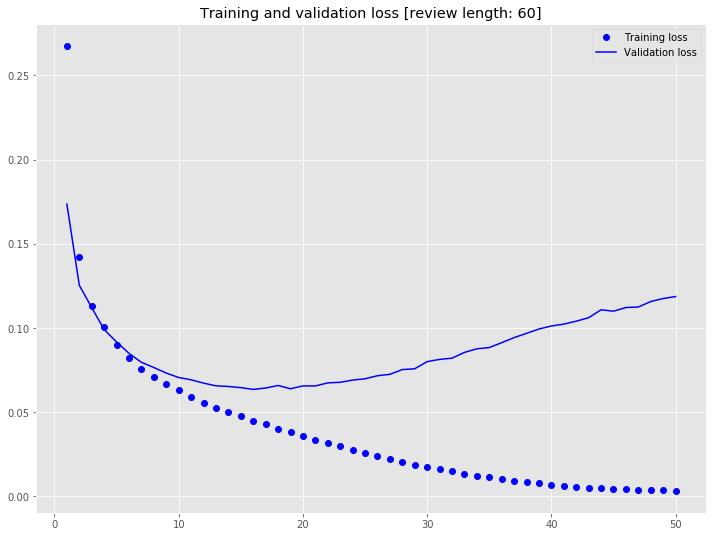

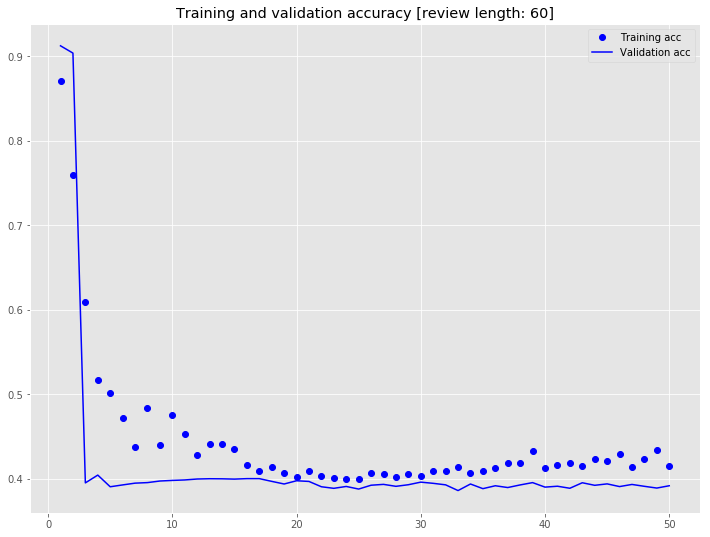

In [32]:
plot_history(history)

In [37]:
model2, history2 = create_train_model(train_samples=(train_x, train_y),
                                    dev_samples=(dev_x, dev_y),
                                    embedding_matrix=emb_matrix,
                                    dropout=0.4, 
                                    epochs=50)

Creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 60, 100)           40000000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 256)           234496    
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 60, 3)             771       
_________________________________________________________________
activation_5 (Activation)    (None, 60, 3)             0         
Total params: 40,235,267
Trainable params: 235,267
Non-trainable params: 40,000,000
________________________________________

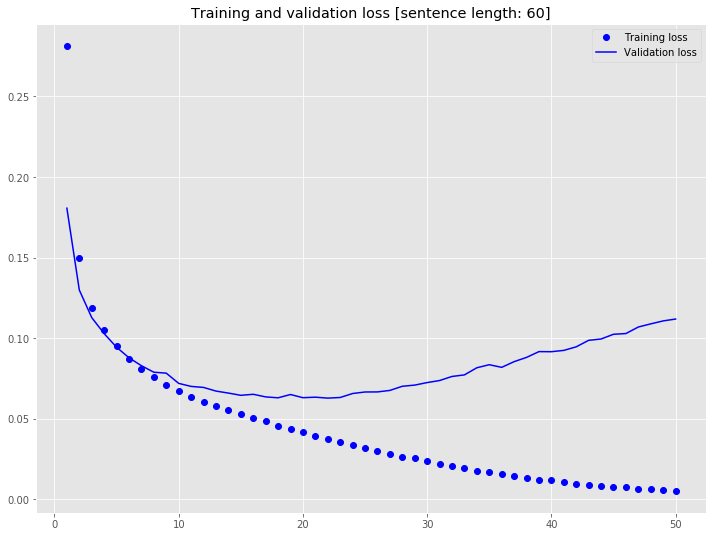

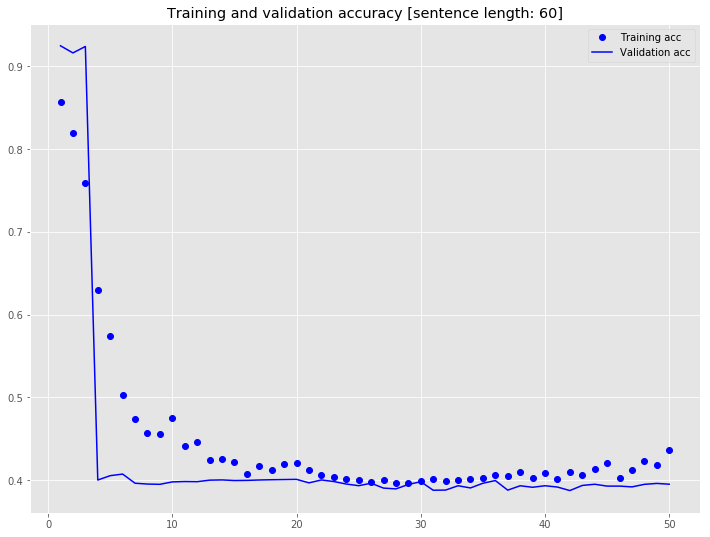

In [38]:
plot_history(history2)

## 8. Evaluation

In [ ]:
def save_to_file(model, word_index):
    model.save('chunking_trained_model.h5')

    with open('word_index.json', 'w') as file:
        json.dump(word_index, file)

save_to_file(model, word_index)

In [ ]:
def print_predictions(model, test_data):
    
    class_map = {
        0: 'B',
        1: 'I',
        2: 'O'
    }
    
    test_x = test_data[0]
    test_y = test_data[1]
    
    preds = model.predict(test_x)
    
    for pred_sample, target_sample, input_sample in zip(preds, test_y, test_x):
       
        # Filter out padding
        valid_indices = np.where(np.sum(target_sample == [0, 0, 0], axis=1) == OUTPUT_DIMENSION - 1)
        pred_outputs = np.argmax(pred_sample[valid_indices], axis=1)
        target_outputs = np.argmax(target_sample[valid_indices], axis=1)
        inputs_valid = input_sample[valid_indices]
        
        # Print actual sentences, targets, and predicted targets in format: 
        # <word> (<target>, <pred_target>) ...
        for i, (target_output, pred_output, word) in enumerate(zip(target_outputs, pred_outputs, inputs_valid)):
            print(reverse_word_index.get(word), end=' ')
            print("(", end='')
            print(class_map[target_output], end=',')
            print(class_map[pred_output], end='')
            print(")", end=' ')
        print()
        print("-" * 30)

print_predictions(model2, (test_x, test_y))

## 9. Conclusions and further improvements